In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io as sio
from scipy import signal
import copy
from scipy.interpolate import griddata
from matplotlib.pyplot import figure
from termcolor import colored
import matplotlib

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100


---
# VIDEO: Local maxima and minima
---


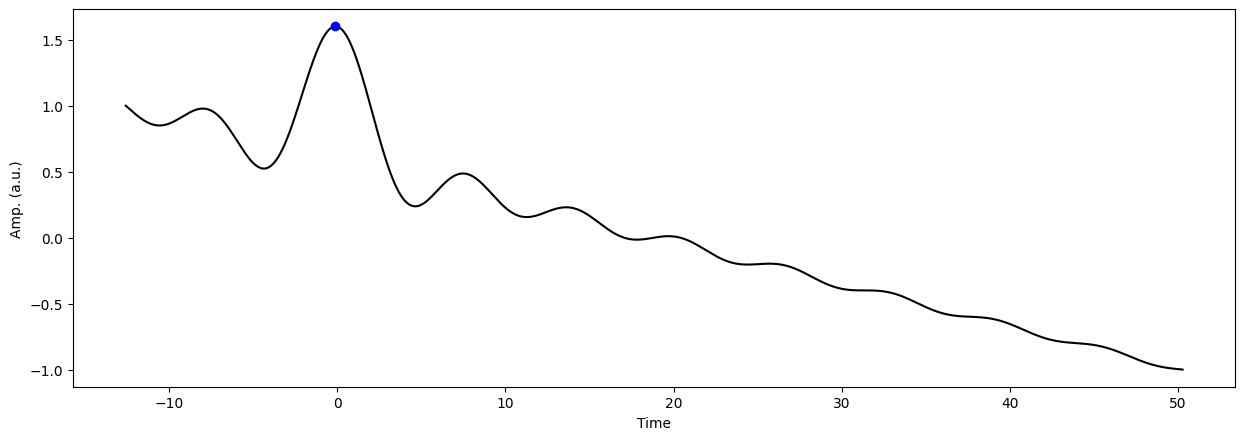

In [ ]:
# signal is sinc plus linear trend
time    = np.linspace(-4*np.pi,16*np.pi,1000)
signal1 = np.sin(time)/time + np.linspace(1,-1,len(time))

# find global maximum
maxval = np.max(signal1)
maxidx = np.argmax(signal1)

# plot the signal and its maximum
plt.plot(time,signal1,'k')
plt.xlabel('Time')
plt.ylabel('Amp. (a.u.)')
plt.plot(time[maxidx],maxval,'bo')
plt.show()

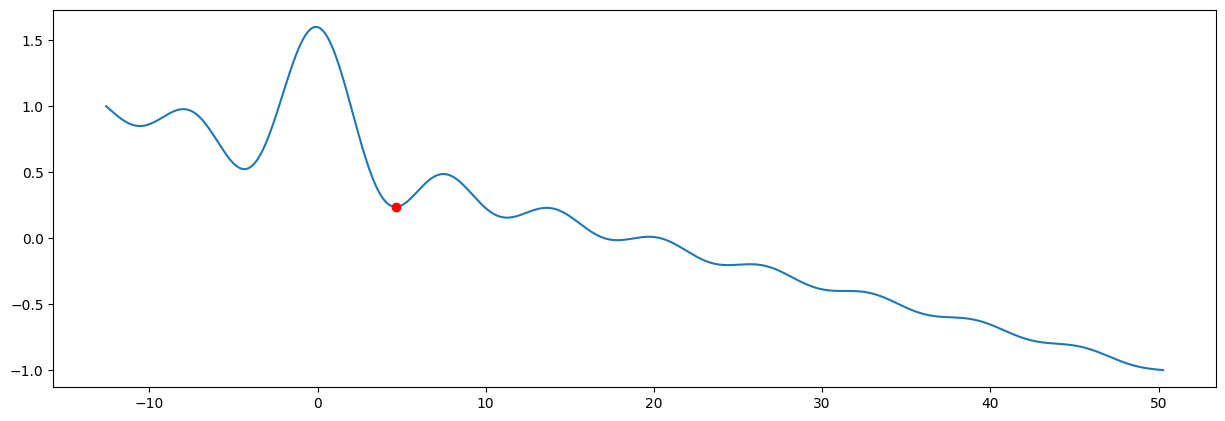

In [ ]:
## "hack" method for local extrema

# "local" minimum is the "global" minimum in a restricted range
range4max = [0,5]
rangeidx = [ np.argmin((time-x)**2) for x in range4max ]

maxLval = np.min( signal1[range(rangeidx[0],rangeidx[1])] )
maxLidx = np.argmin( signal1[range(rangeidx[0],rangeidx[1])] )


# plot it
plt.plot(time,signal1)
plt.plot(time[maxLidx+rangeidx[0]],maxLval,'ro')
plt.show()

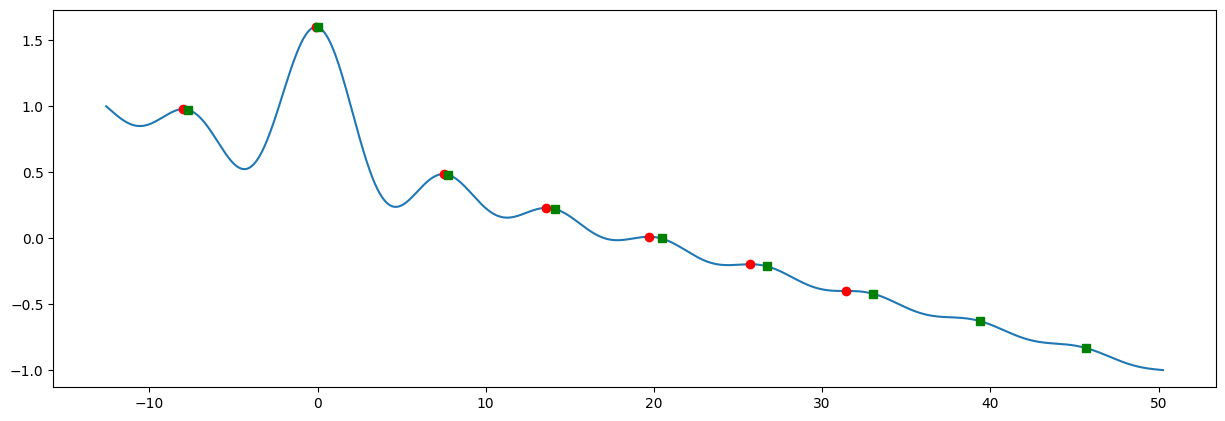

In [ ]:
## local minima/maxima

# find local maxima and plot
peeks1 = np.squeeze( np.where(np.diff(np.sign(np.diff(signal1)))<0) )+1
 
plt.plot(time,signal1)
plt.plot(time[peeks1],signal1[peeks1],'ro')

# try again using detrended signal
peeks2 = np.squeeze( np.where(np.diff(np.sign(np.diff( scipy.signal.detrend(signal1) )))<0) )+1
plt.plot(time[peeks2],signal1[peeks2],'gs')

plt.show()

notes:
differiative of signal


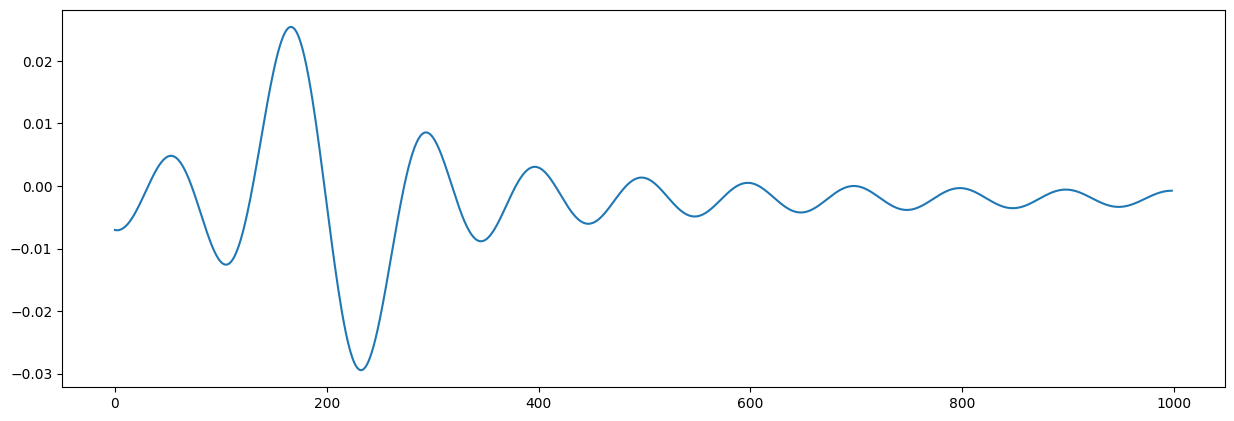

In [ ]:
print(colored("notes:", "red"))
print(colored("differiative of signal", "red"))
plt.plot(np.diff(signal1))

notes:
sign value of differiative of signal


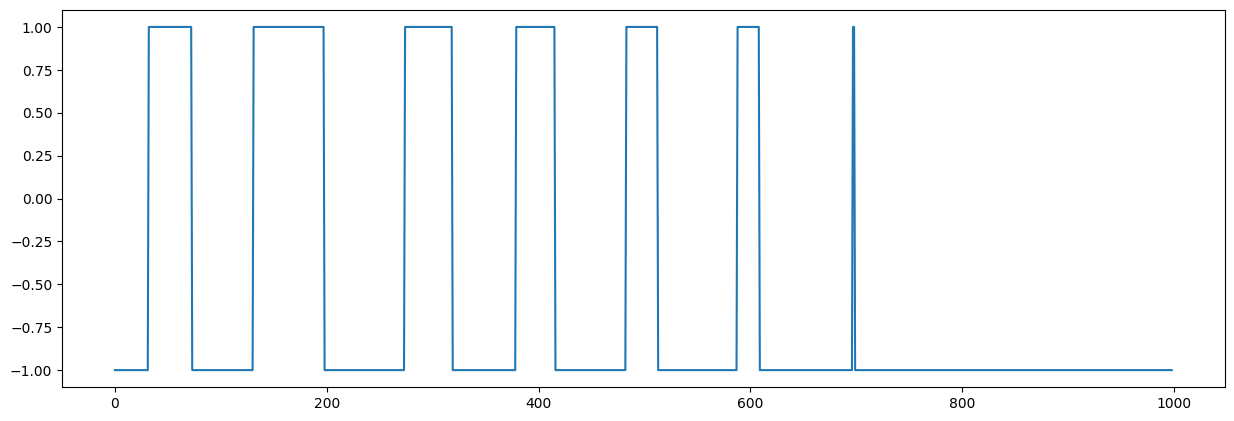

In [ ]:
print(colored("notes:", "red"))
print(colored("sign value of differiative of signal", "red"))
plt.plot(np.sign(np.diff(signal1)))

notes:
differiative of the sign
local maximum is the value below 0


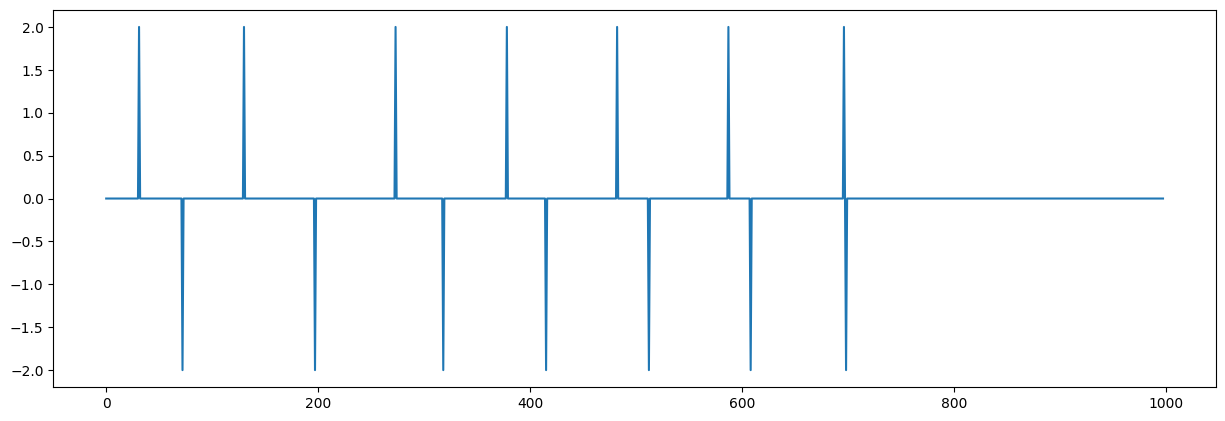

In [ ]:
print(colored("notes:", "red"))
print(colored("differiative of the sign", "red"))
print(colored("local maximum is the value below 0", "red"))

plt.plot(np.diff(np.sign(np.diff(signal1))))

# VIDEO: Recover signal from noise amplitude

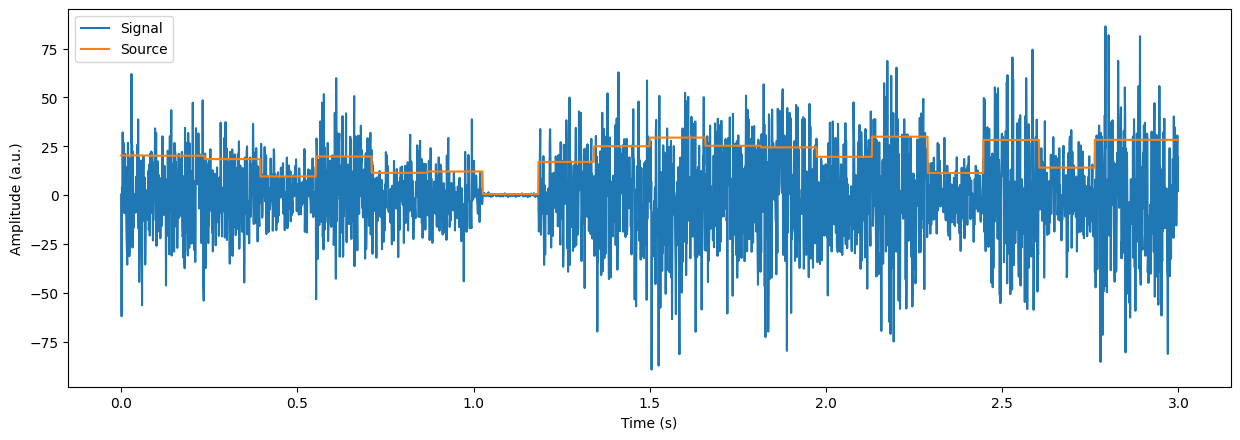

In [ ]:
## create the signal

# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 20 # poles for random interpolation

# amplitude modulator and noise level
ampmod = griddata(np.arange(0,p), np.random.rand(p)*30, np.linspace(1,p,n), method='nearest')

signal1 = ampmod * np.random.randn(n)

# plot
figure(figsize=(15, 5))
plt.plot(time,signal1,label='Signal')
plt.plot(time,ampmod,label='Source')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.legend()
plt.show()

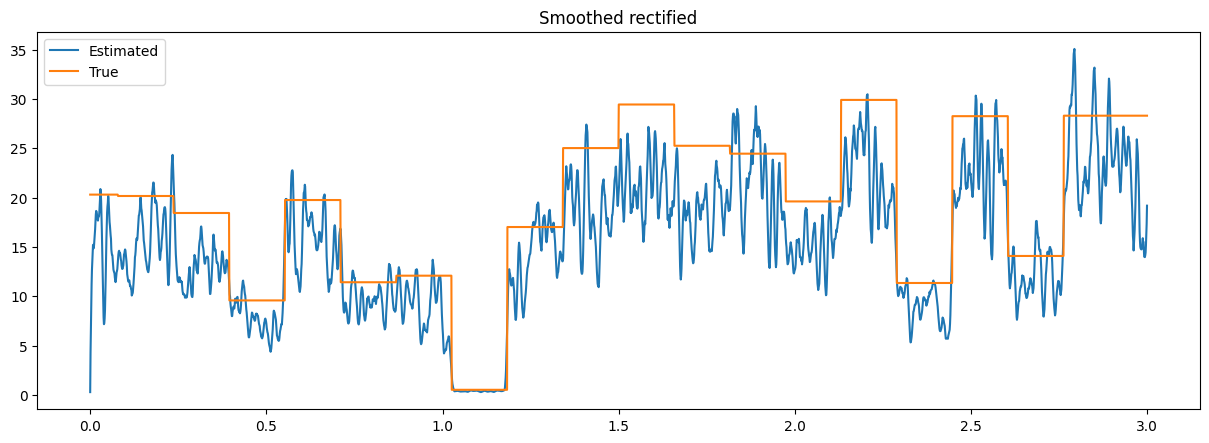

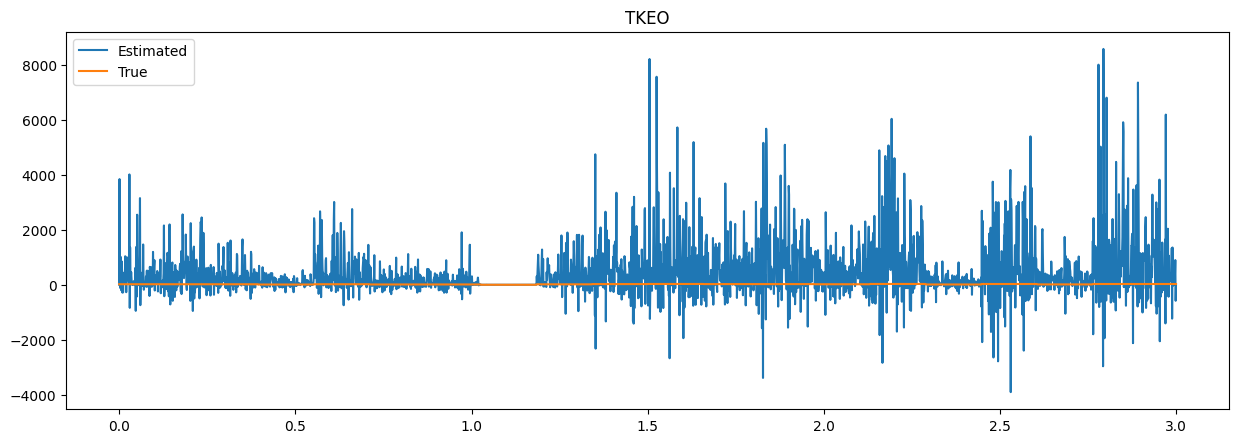

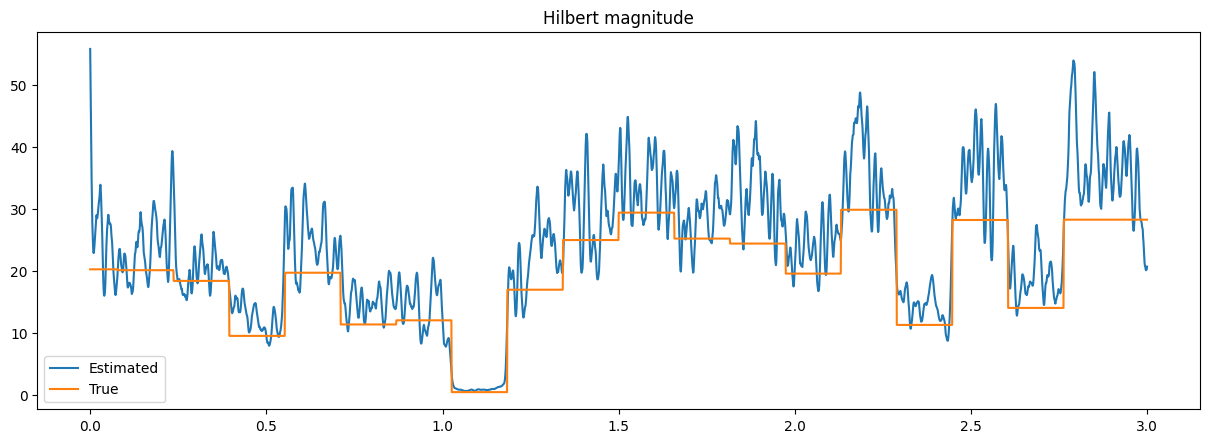

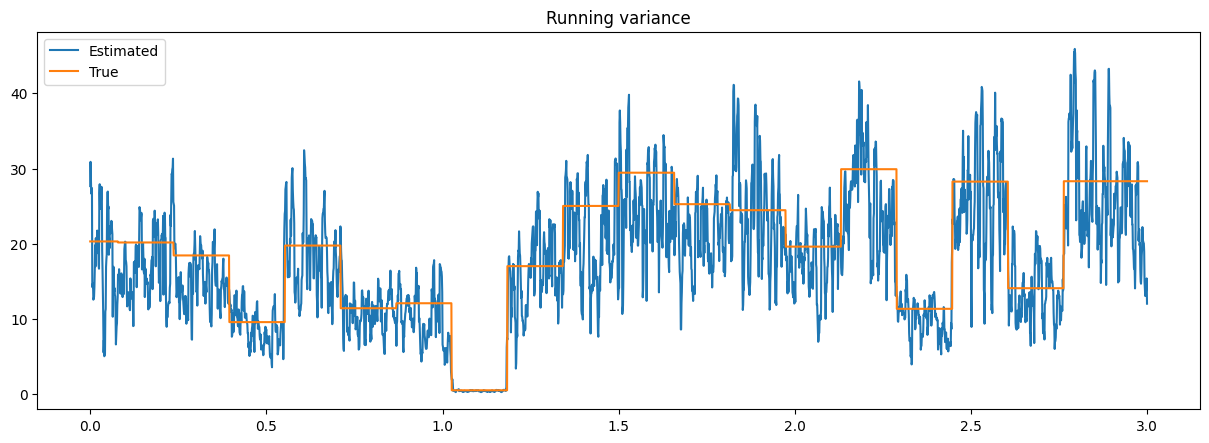

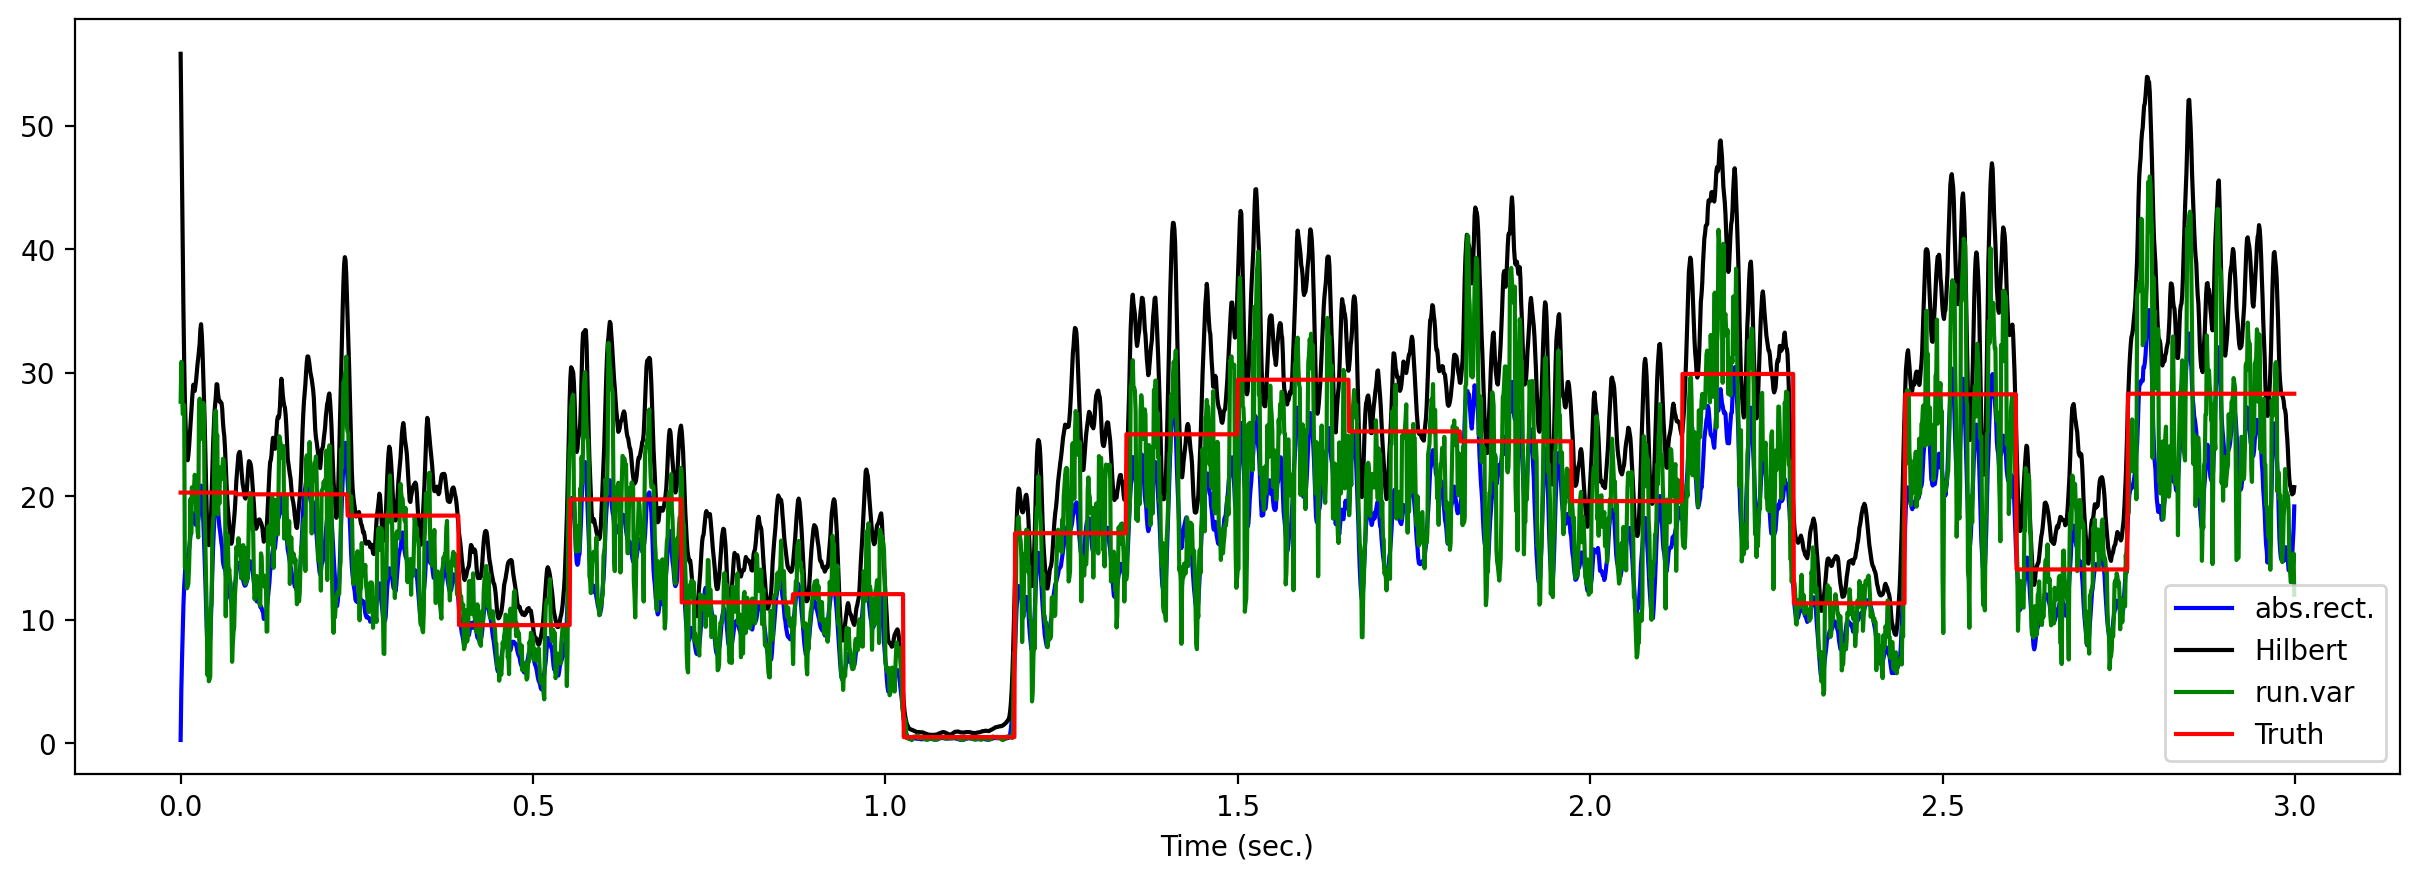

In [ ]:
## options for identifying the original signal


# rectify (remove negative values) and lowpass filter
rectsig = np.abs(signal1)
k = 9
rectsig = signal.filtfilt(np.ones(k)/k,1,rectsig)
figure(figsize=(15, 5))
plt.plot(time,rectsig,label='Estimated')
plt.plot(time,ampmod,label='True')
plt.legend()
plt.title('Smoothed rectified')
plt.show()


# TKEO
tkeosig = copy.deepcopy( signal1 )
tkeosig[1:-1] = signal1[1:-1]**2 - signal1[0:-2]*signal1[2:]
figure(figsize=(15, 5))
plt.plot(time,tkeosig,label='Estimated')
plt.plot(time,ampmod,label='True')
plt.legend()
plt.title('TKEO')
plt.show()


# magnitude of Hilbert transform
maghilb = np.abs(scipy.signal.hilbert( signal1 ))

# running mean-filter
k = 9
maghilb = signal.filtfilt(np.ones(k)/k,1,maghilb)
figure(figsize=(15, 5))
plt.plot(time,maghilb,label='Estimated')
plt.plot(time,ampmod,label='True')
plt.legend()
plt.title('Hilbert magnitude')
plt.show()


# running-variance
k = 9
runningVar = np.zeros(n)
for i in range(0,n):
    startp = np.max((0,i-int(k/2)))
    endp   = np.min((int(k/2)+i,n))
    
    runningVar[i] = np.std( signal1[range(startp,endp)] )

figure(figsize=(15, 5))
plt.plot(time,runningVar,label='Estimated')
plt.plot(time,ampmod,label='True')
plt.legend()
plt.title('Running variance')
plt.plot()


### plot all options
figure(figsize=(15, 5), dpi=200)
plt.plot(time,rectsig,'b',label='abs.rect.')
# plt.plot(time,tkeosig,'m',label='TKEO')
plt.plot(time,maghilb,'k',label='Hilbert')
plt.plot(time,runningVar,'g',label='run.var')
plt.plot(time,ampmod,'r',label='Truth')

plt.legend()
plt.xlabel('Time (sec.)')
plt.show()

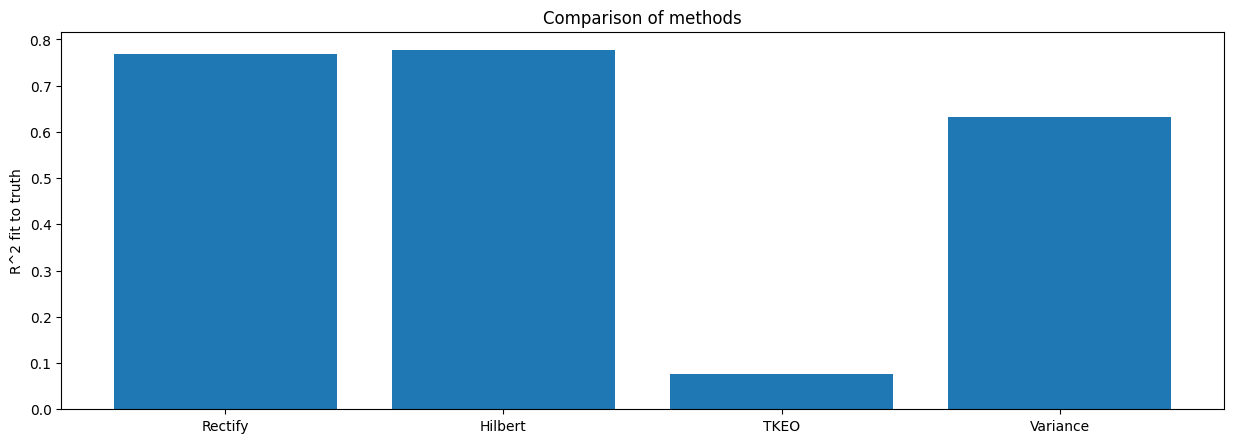

In [ ]:
## compare the different algorithms to ground truth

# rectify
r2rect = np.corrcoef(ampmod,rectsig)
r2rect = r2rect[0,1]**2

# TKEO
r2tkeo = np.corrcoef(ampmod,tkeosig)
r2tkeo = r2tkeo[0,1]**2

# Hilbert
r2hilb = np.corrcoef(ampmod,maghilb)
r2hilb = r2hilb[0,1]**2

# running variance
r2varr = np.corrcoef(ampmod,runningVar)
r2varr = r2varr[0,1]**2


# now plot
plt.bar(np.arange(1,5),[ r2rect, r2hilb, r2tkeo, r2varr ])
plt.xticks([1,2,3,4],('Rectify','Hilbert','TKEO','Variance'))
plt.ylabel('R^2 fit to truth')
plt.title('Comparison of methods')

# optional zoom
#plt.ylim([.8, .9])

plt.show()


---
# VIDEO: Wavelet convolution for feature extraction
---


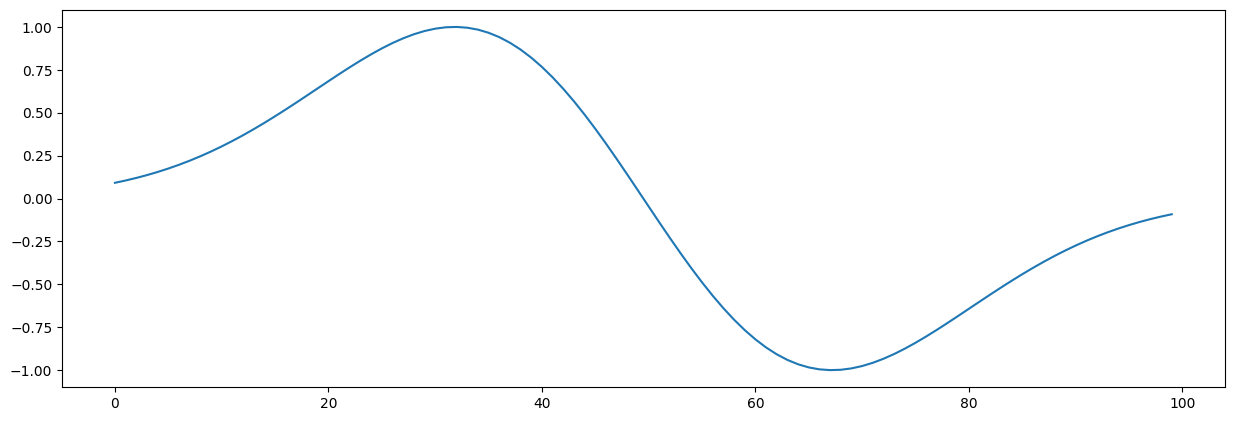

notes:
could change the noise level from .1 to other value to see how it affect the prediction curve (average curve at the end)


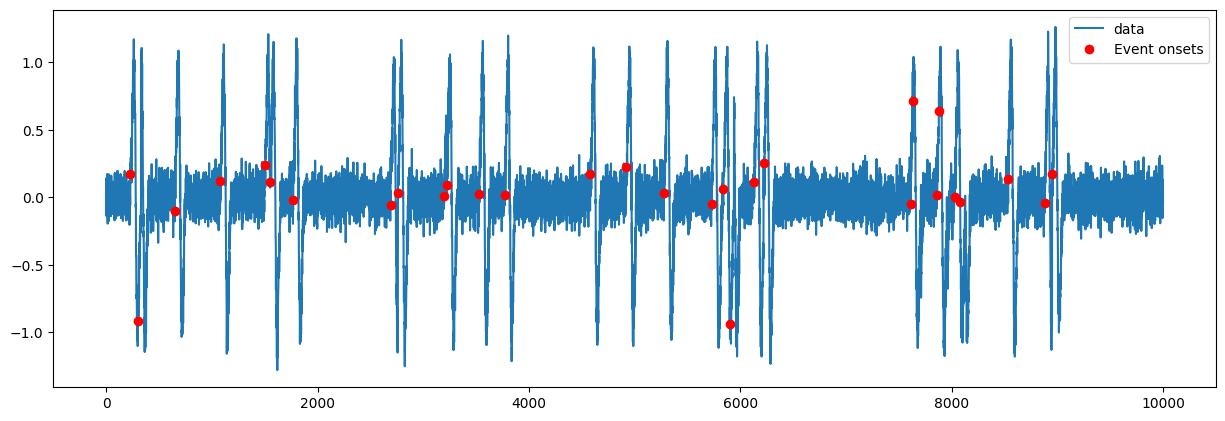

In [ ]:
## simulate data 
# taken from video "Averaging multiple repetitions (time-synchronous averaging)"

# total number of time points
N = 10000

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp( -np.linspace(-2,2,k+1)**2 ))
event = event/np.max(event) # normalize to max=1

plt.plot(event)
plt.show()

# event onset times
Nevents = 30
onsettimes = np.random.permutation( int(N/10-k) )
onsettimes = onsettimes[range(0,Nevents)]*10

# put event into data
data = np.zeros(N)
for ei in range(0,Nevents):
    data[range(onsettimes[ei],onsettimes[ei]+k)] = event

# add noise
print(colored("notes:", "red"))
print(colored("could change the noise level from .1 to other value to see how it affect the prediction curve (average curve at the end)", "red"))

data = data + .1*np.random.randn(N)



# plot data
plt.plot(data,label='data')
plt.plot(onsettimes,data[onsettimes],'ro',label='Event onsets')
plt.legend()
plt.show()

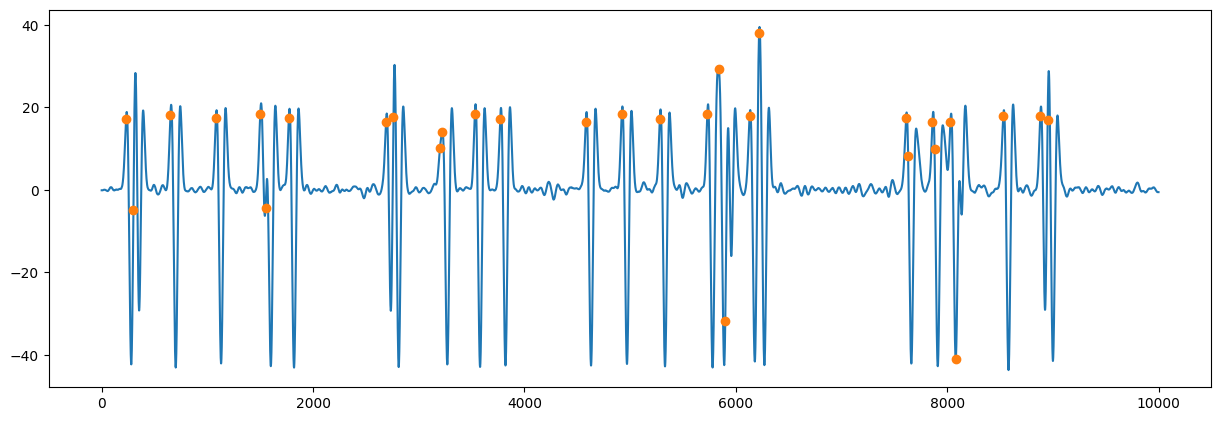

In [ ]:
## convolve with event (as template)

# convolution
convres = scipy.signal.convolve(data,event,'same')


# plot the convolution result and ground-truth event onsets
plt.plot(convres)
plt.plot(onsettimes,convres[onsettimes],'o')
plt.show()

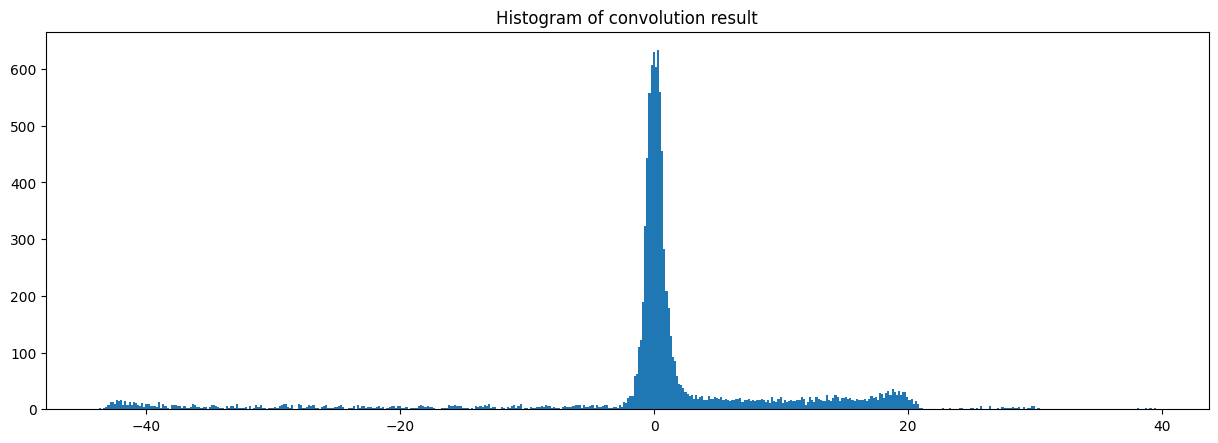

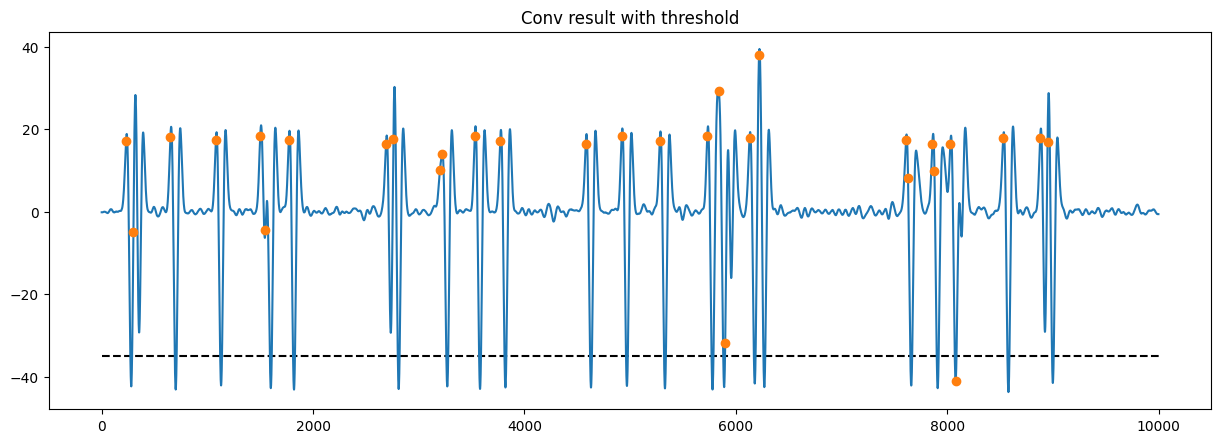

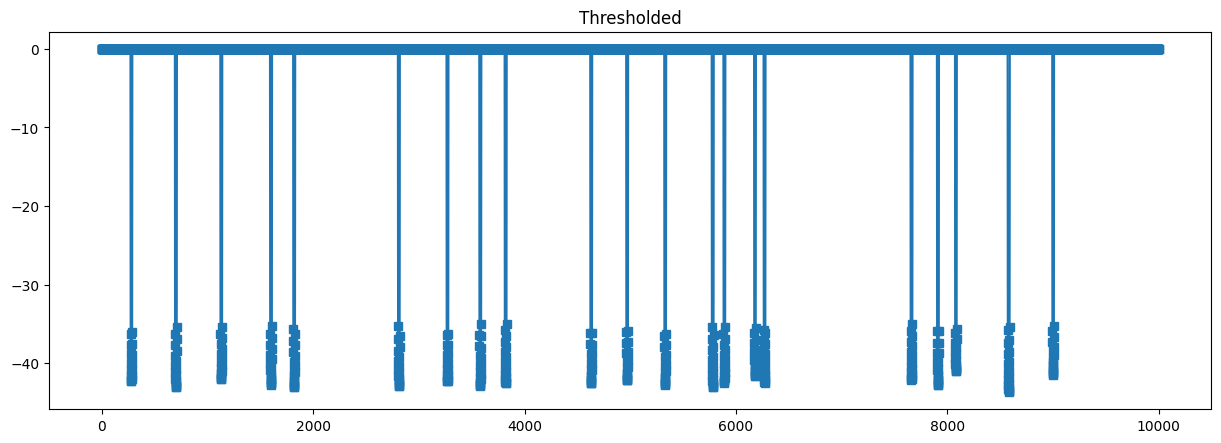

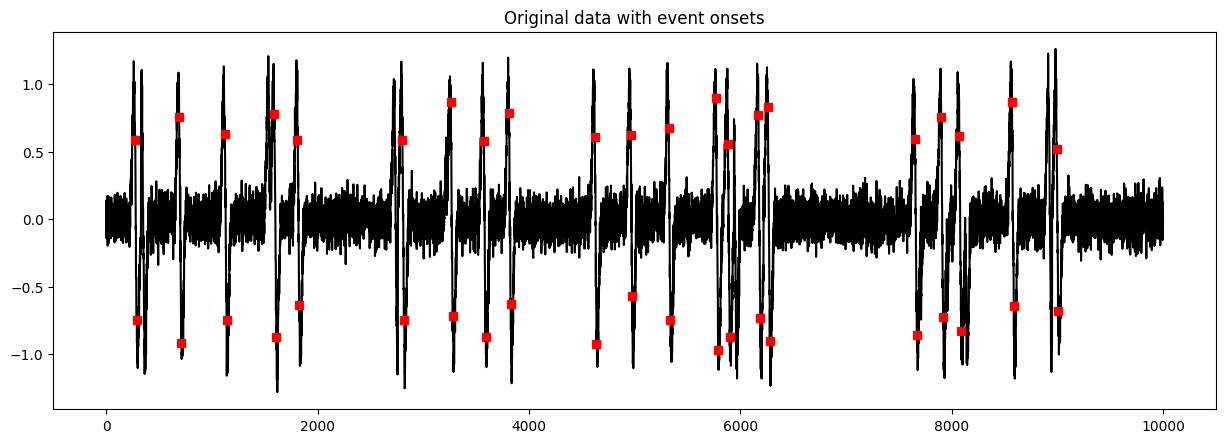

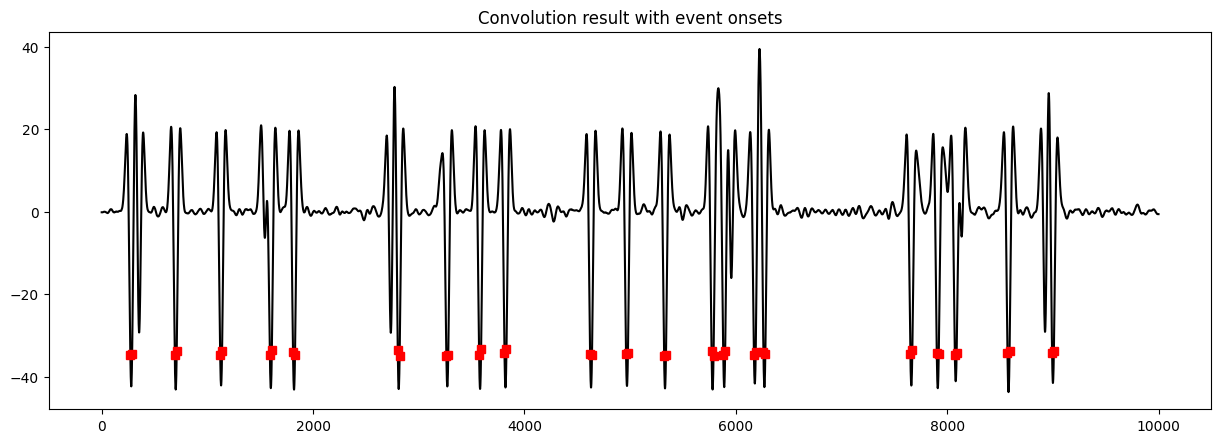

In [ ]:
## find a threshold

#% histogram of all data values
plt.hist(convres,int(N/20))
plt.title('Histogram of convolution result')
plt.show()


# pick a threshold based on histogram and visual inspection
thresh = -35


# plot the threshold
plt.plot([0,N],[thresh,thresh],'k--')
plt.plot(convres)
plt.plot(onsettimes,convres[onsettimes],'o')
plt.title('Conv result with threshold')
plt.show()


# find local minima
thresh_ts = copy.deepcopy( convres )
thresh_ts[thresh_ts>thresh] = 0


# let's see what it looks like...
plt.plot(thresh_ts,'s-')
plt.title('Thresholded')
plt.show()

# find local minima
localmin = np.squeeze( np.where(np.diff(np.sign(np.diff(thresh_ts)))<0) )+1


# plot local minima on top of the plot
plt.plot(data,'k')
plt.plot(localmin,data[localmin],'rs')
plt.title('Original data with event onsets')
plt.show()

# plot convolution result
plt.plot(convres,'k')
plt.plot(localmin,convres[localmin],'rs')
plt.title('Convolution result with event onsets')
plt.show()

events captured: 42


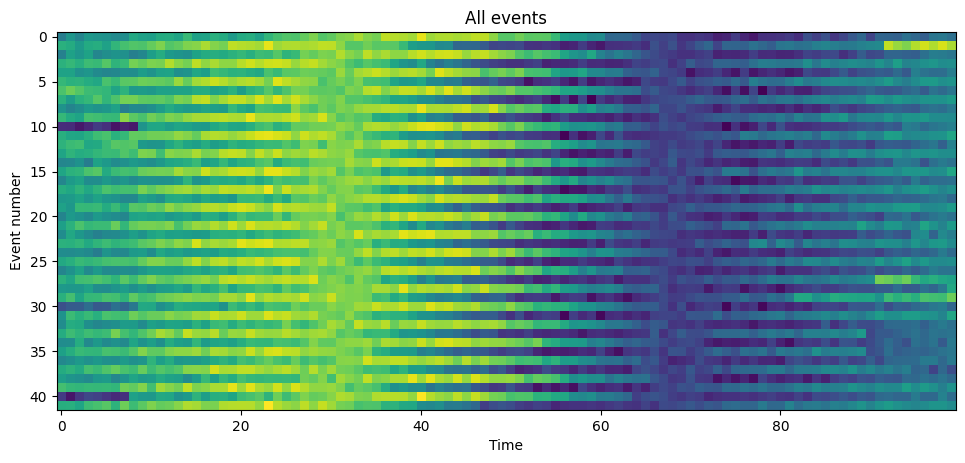

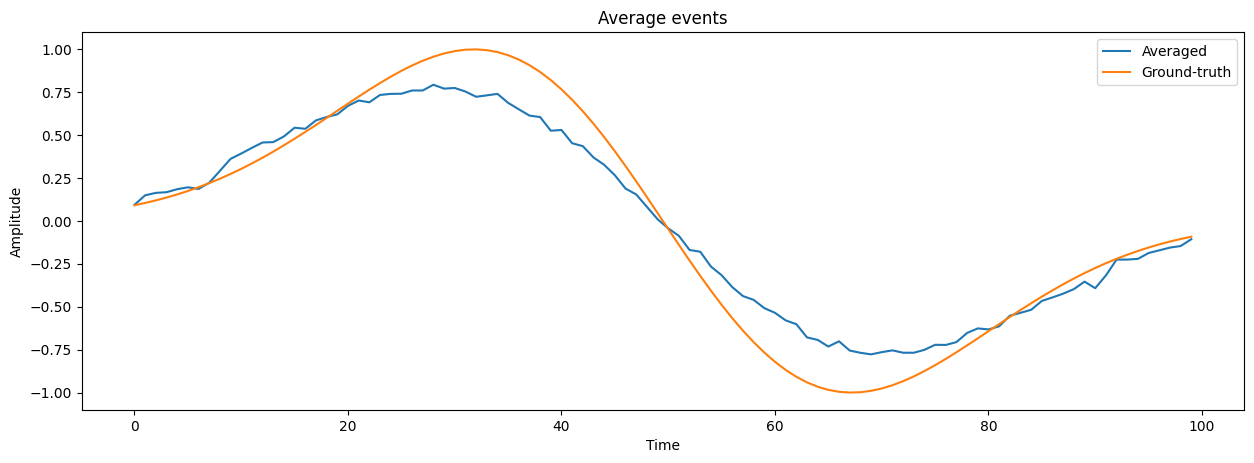

In [ ]:
## now extract time series for windowing

# remove local minima that are too close to the edges
localmin = np.delete(localmin,np.where(localmin<k//2))
localmin = np.delete(localmin,np.where(localmin>(N-k//2)))


# initialize data matrix
datamatrix = np.zeros((len(localmin),k))

# enter data snippets into matrix
for ei in range(0,len(localmin)):
    datamatrix[ei,:] = data[ range(localmin[ei]-int(k/2),localmin[ei]+int(k/2)) ]

print("events captured: {}".format(len(datamatrix)))
# show all snippets
plt.imshow(datamatrix)
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.show()

# snippet average against ground truth
plt.plot(np.arange(0,k),np.mean(datamatrix,axis=0),label='Averaged')
plt.plot(np.arange(0,k),event,label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()



---
# VIDEO: Area under the curve
---


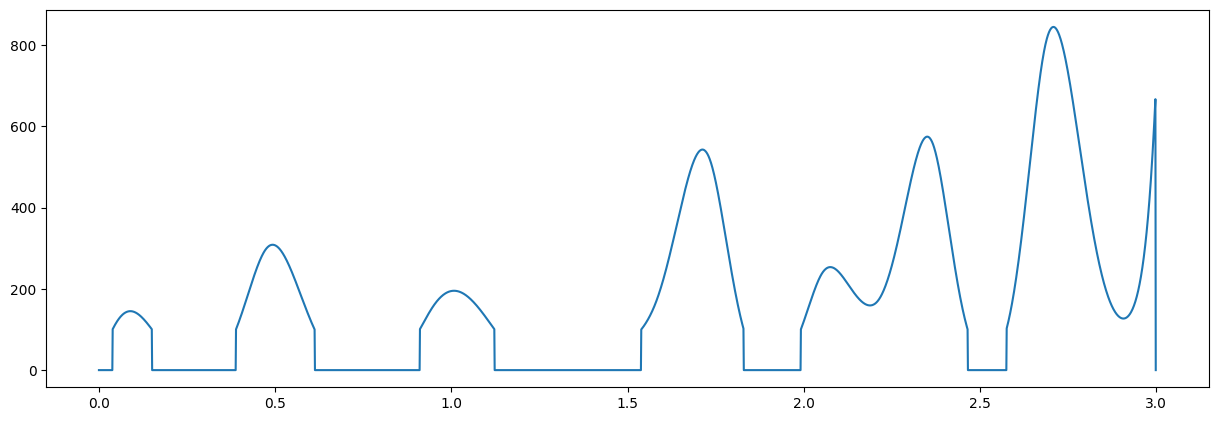

In [ ]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 20  # poles for random interpolation

# amplitude modulator and noise level
signal1 = griddata(np.arange(0,p), np.random.rand(p)*30, np.linspace(0,p-1,n), method='cubic')**2
signal1[signal1<100] = 0

# force first and last points to be 0
signal1[0]=0
signal1[-1]=0

plt.plot(time,signal1)
plt.show()

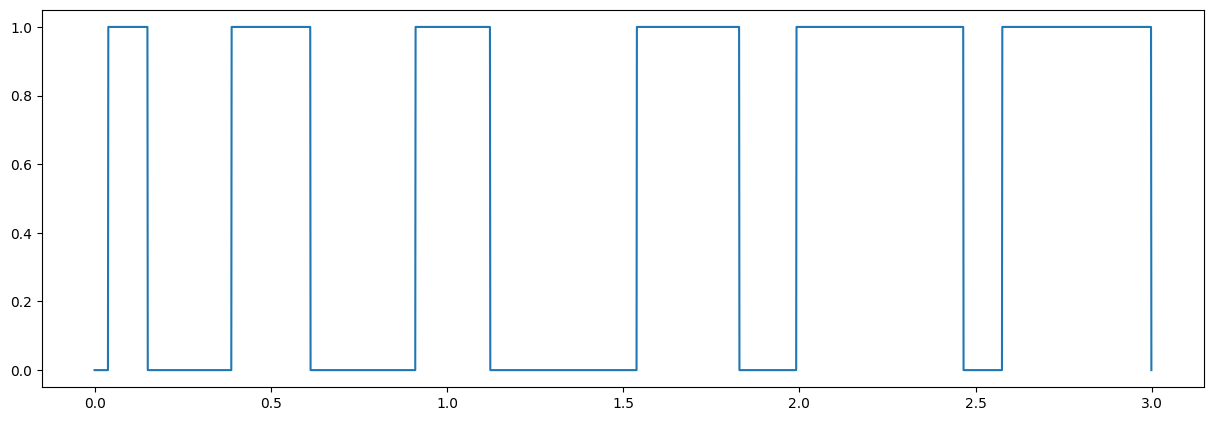

In [ ]:
# thresholded time series
threshts = np.double( signal1>0 )
plt.plot(time,threshts)
plt.show()


dpntsU: [  38  388  910 1538 1991 2575] dpntsD: [ 150  612 1122 1829 2465 2998]
notes:
for each polygon, paint the color from left to right by passing [time, value of function at that particular time]


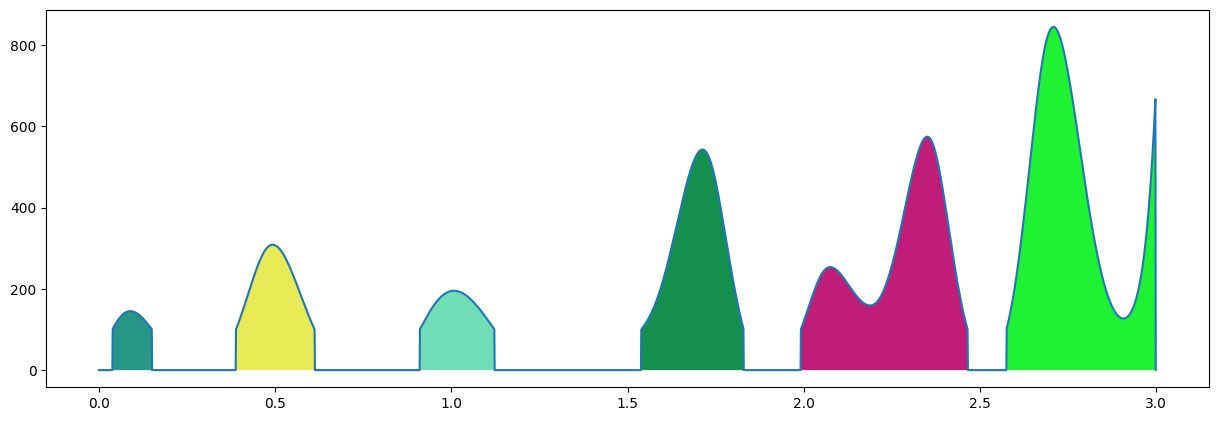

In [ ]:
## demarcate each lobe
from matplotlib.patches import Polygon

# find boundaries
dpntsU = np.squeeze(np.where( np.diff(threshts)>0 ) )
dpntsD = np.squeeze(np.where( np.diff(threshts)<0 ) )

print("dpntsU: {} dpntsD: {}".format(dpntsU, dpntsD))

plt.figure()
plt.plot(time,signal1)

print(colored("notes:", "red"))
print(colored("for each polygon, paint the color from left to right by passing [time, value of function at that particular time]", "red"))

axes = plt.gca()
for i in range(0,len(dpntsD)):
    # create polygon object (xy pair for each row)
    x = []
    # from left to right in a signle polygon
    for ii in range(dpntsU[i],dpntsD[i]):
        x.append(np.array([time[ii],signal1[ii]]))
    x.append(np.array([time[dpntsD[i]+1],signal1[dpntsD[i]+1]]))
    axes.add_patch(Polygon(x,closed=True,facecolor=np.random.rand(3)))


plt.show()


(6,)
[0.001 0.001 0.001 ... 0.001 0.001 0.001]


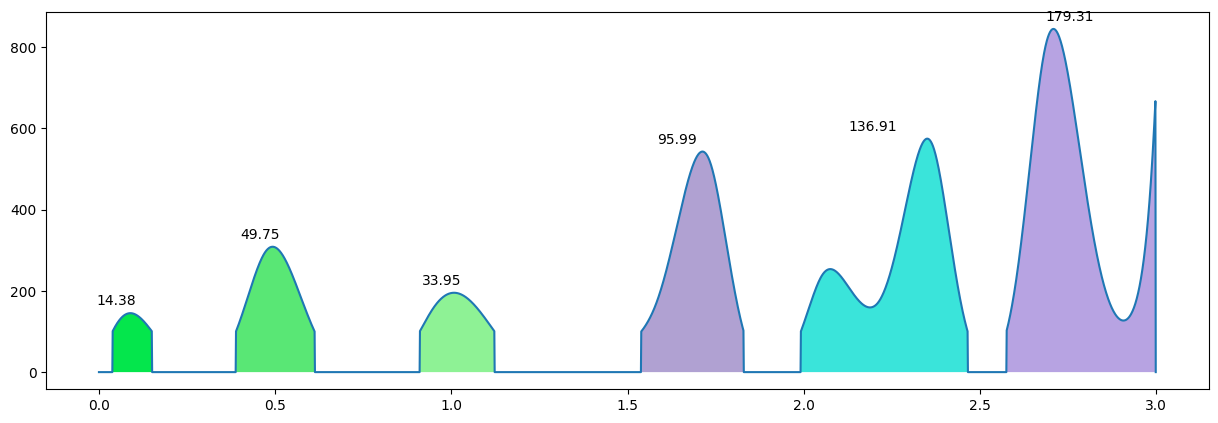

In [ ]:
## compute AUC (Area under the ROC Curve) under each curve

auc = np.zeros(len(dpntsU))
print(auc.shape)
for ii in range(0,len(dpntsU)):
    auc[ii] = np.sum( signal1[ range(dpntsU[ii],dpntsD[ii]) ] )

# scale by dt
auc = auc * np.mean(np.diff(time))
print(np.diff(time))
### Add text to patches

plt.figure()
plt.plot(time,signal1)

axes = plt.gca()
for i in range(0,len(dpntsD)):
    
    # create polygon object (xy pair for each row)
    x = []
    for ii in range(dpntsU[i],dpntsD[i]):
        x.append(np.array([time[ii],signal1[ii]]))
    x.append(np.array([time[dpntsD[i]+1],signal1[dpntsD[i]+1]]))
    
    axes.add_patch(Polygon(x,closed=True,facecolor=np.random.rand(3)))
    
    # here's the text
    xpoint = (time[dpntsU[i]]+time[dpntsD[i]])/2 - .1
    ypoint = np.max(signal1[range(dpntsU[i],dpntsD[i])])+20
    plt.text(xpoint,ypoint,np.round(auc[i],2))


plt.show()


---
# VIDEO: Detect muscle movements from EMG recordings
---


(200,)
[769.53125   586.9140625 656.25      579.1015625 803.7109375 685.546875
 625.9765625 639.6484375 636.71875   541.9921875 512.6953125 483.3984375
 532.2265625 534.1796875 508.7890625 459.9609375 415.0390625 557.6171875
 414.0625    736.328125  462.890625  539.0625    443.359375  453.125
 510.7421875 659.1796875 330.078125  404.296875  459.9609375 401.3671875
 475.5859375 434.5703125 380.859375  480.46875   549.8046875 391.6015625
 373.046875  450.1953125 391.6015625 599.609375  367.1875    384.765625
 479.4921875 387.6953125 415.0390625 515.625     499.0234375 495.1171875
 453.125     403.3203125]


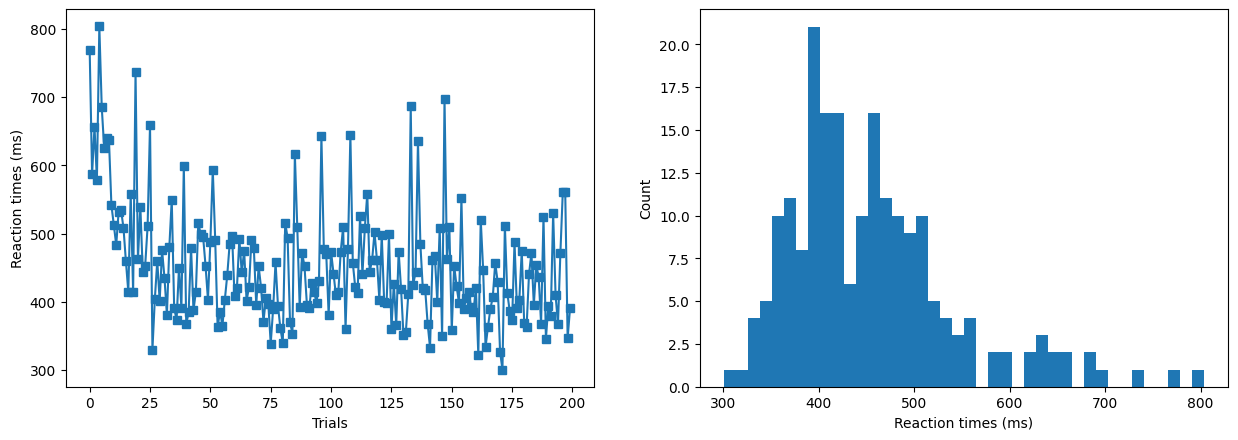

notes:
print EMG data sorted by reaction time


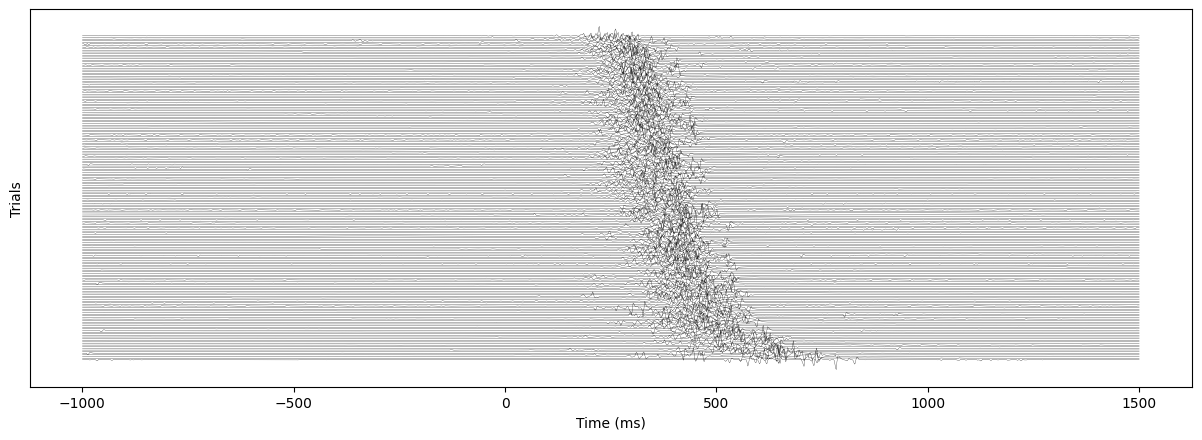

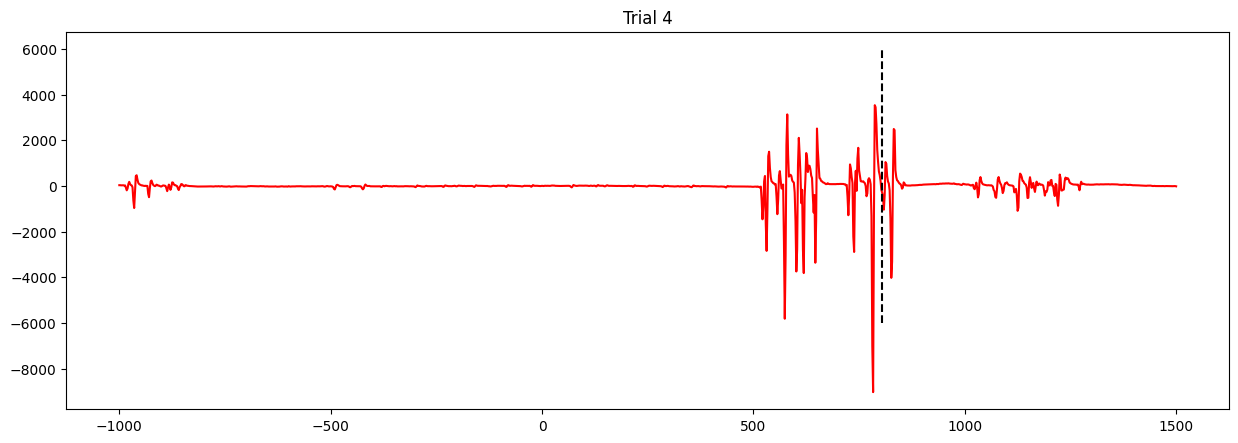

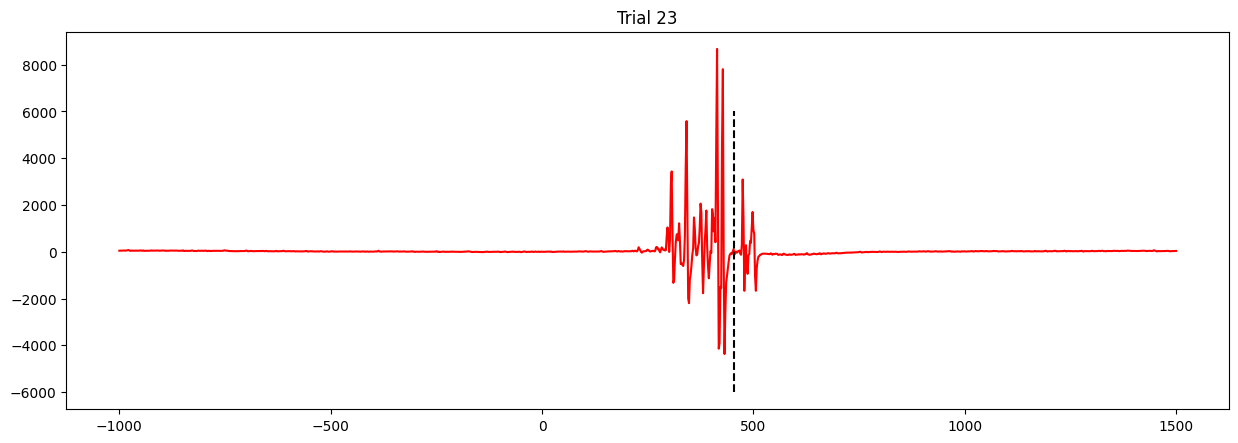

In [ ]:
# load data
matdat = sio.loadmat('EMGRT.mat')
emg = matdat['emg']
rts = np.squeeze(matdat['rts'])
timevec = np.squeeze(matdat['timevec'])

print(rts.shape)
print(rts[:50])

N = len(rts)

# example trials
trials2plot = [ 4, 23 ]


### a few plots to get an idea of the data

# RTs (button presses)
plt.subplot(121)
plt.plot(rts,'s-')
plt.xlabel('Trials')
plt.ylabel('Reaction times (ms)')

# histogram of RTs
plt.subplot(122)
plt.hist(rts,40)
plt.xlabel('Reaction times (ms)')
plt.ylabel('Count')
plt.show()


print(colored("notes:", "red"))
print(colored("print EMG data sorted by reaction time", "red"))

# EMG time series, sorted by RTs
sidx = np.argsort(rts)[::-1]

for i in range(N):
    plt.plot(timevec,emg[sidx[i],:]+i*1500,'k',linewidth=.2)

plt.xlabel('Time (ms)')
plt.ylabel('Trials')
plt.yticks([], [])
plt.show()



# plt two example trials
for i in range(0,2):
    
    # plot EMG trace
    plt.plot(timevec,emg[trials2plot[i],:],'r')
    
    # overlay button press time
    plt.plot([rts[trials2plot[i]], rts[trials2plot[i]]],[-6000, 6000],'k--')
    plt.title('Trial %d' %trials2plot[i])
    plt.show()


In [ ]:
# detect EMG onsets

# define baseline time window for normalization
baseidx = [0,0]
baseidx[0] = np.argmin((timevec--500)**2)
baseidx[1] = np.argmin((timevec)**2)

# pick z-threshold
zthresh = 100

# initialize outputs
emgonsets = np.zeros(N)

for triali in range(0,N):
    
    # convert to energy via TKEO
    tkeo = emg[triali,1:-1]**2 - emg[triali,0:-2]*emg[triali,2:]
    # for convenience, make the TKEO the same length as the time vector
    tkeo = np.append(0,tkeo)
    tkeo = np.append(tkeo,0)
    
    # convert to zscore from pre-0 activity
    tkeo = ( tkeo-np.mean(tkeo[range(baseidx[0],baseidx[1])]) ) / np.std(tkeo[range(baseidx[0],baseidx[1])])
    
    # find first suprathreshold point
    tkeoThresh = tkeo>zthresh
    tkeoThresh[timevec<0] = 0
    tkeoPnts = np.squeeze( np.where(tkeoThresh) )
    
    # grab the first suprathreshold point
    emgonsets[triali] = timevec[ tkeoPnts[0]+1 ]


notes:
for each trial, print the first time point where reaction get detected


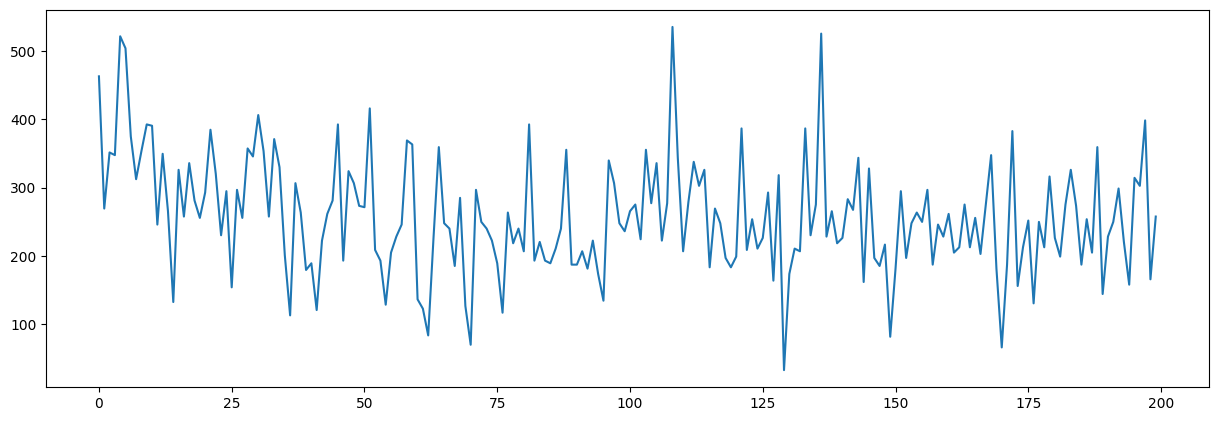

In [ ]:
print(colored("notes:", "red"))
print(colored("for each trial, print the first time point where reaction get detected", "red"))

plt.plot(emgonsets)
plt.show()

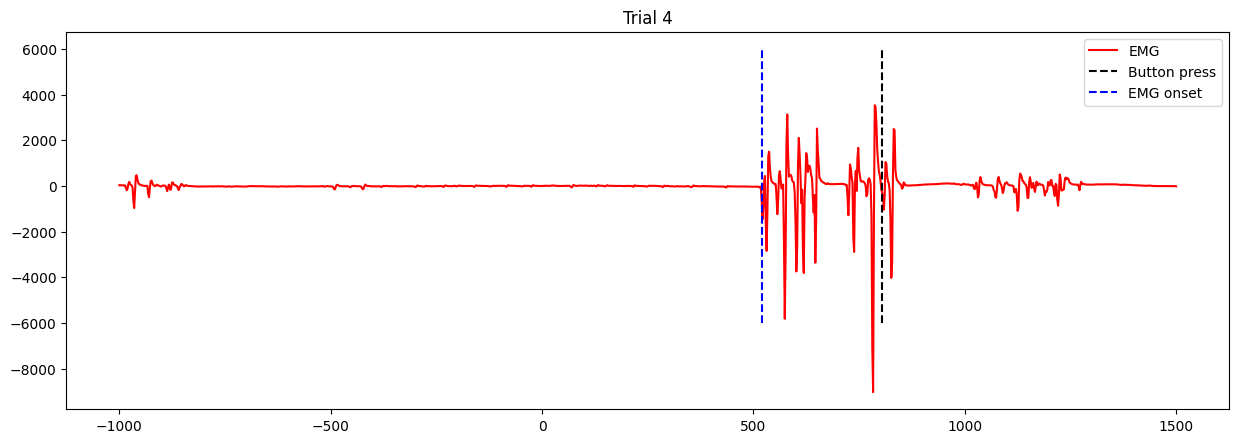

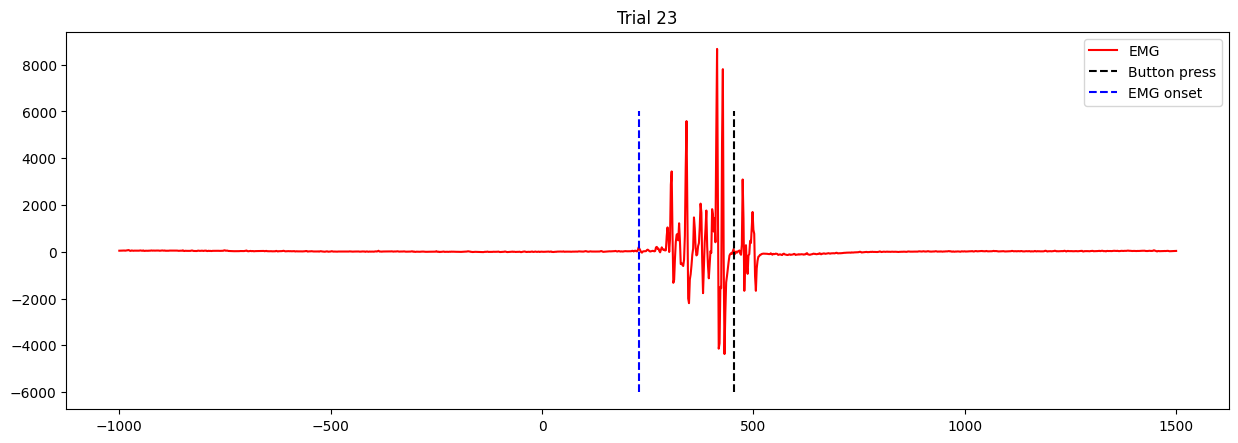

In [ ]:
## more plots

# back to the EMG traces...
for i in range(2):
    
    trial = trials2plot[i]

    # plot EMG trace
    plt.plot(timevec,emg[trial,:],'r',label='EMG')
    
    # overlay button press time
    plt.plot([rts[trial], rts[trial]],[-6000, 6000],'k--',label='Button press')
    plt.title('Trial %d' %trial)
    
    # overlay EMG onset
    xpnt = emgonsets[trial]
    plt.plot([xpnt,xpnt],[-6000, 6000],'b--',label='EMG onset')
    
    plt.legend()
    plt.show()
    

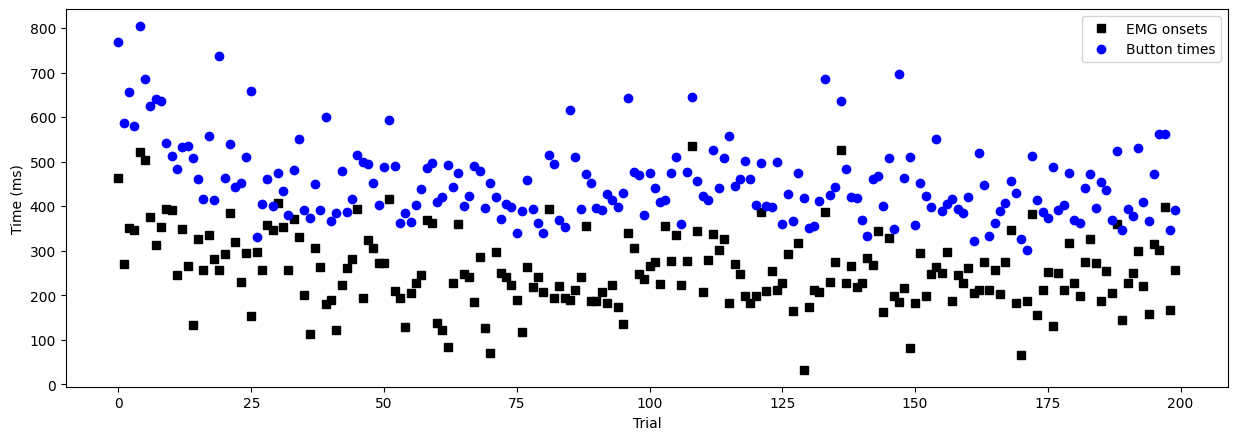

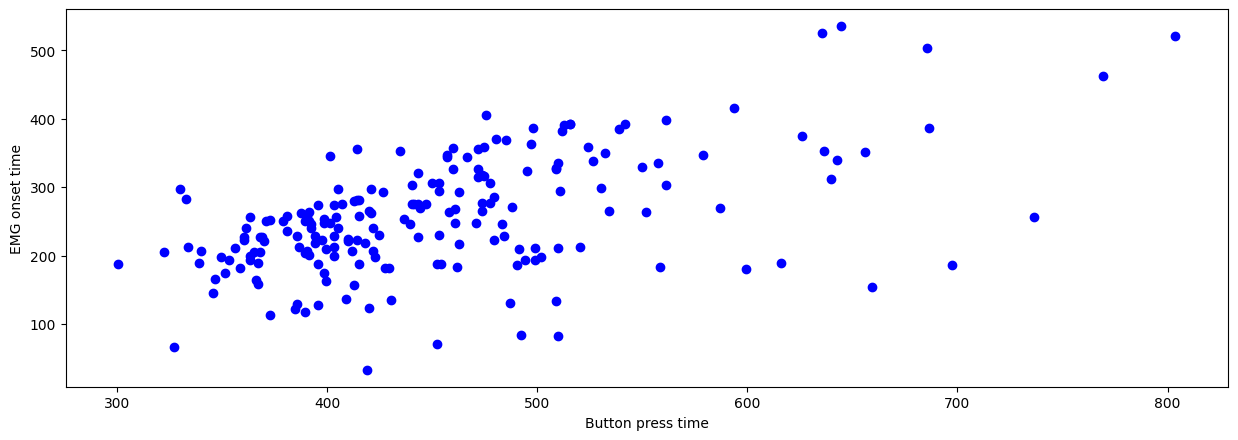

In [ ]:
# plot onsets by RTs
plt.plot(emgonsets,'ks',label='EMG onsets')
plt.plot(rts,'bo',label='Button times')
plt.xlabel('Trial')
plt.ylabel('Time (ms)')
plt.legend()
plt.show()

plt.plot(rts,emgonsets,'bo')
plt.xlabel('Button press time')
plt.ylabel('EMG onset time')
plt.show()



---
# VIDEO: Full-width at half-maximum
---


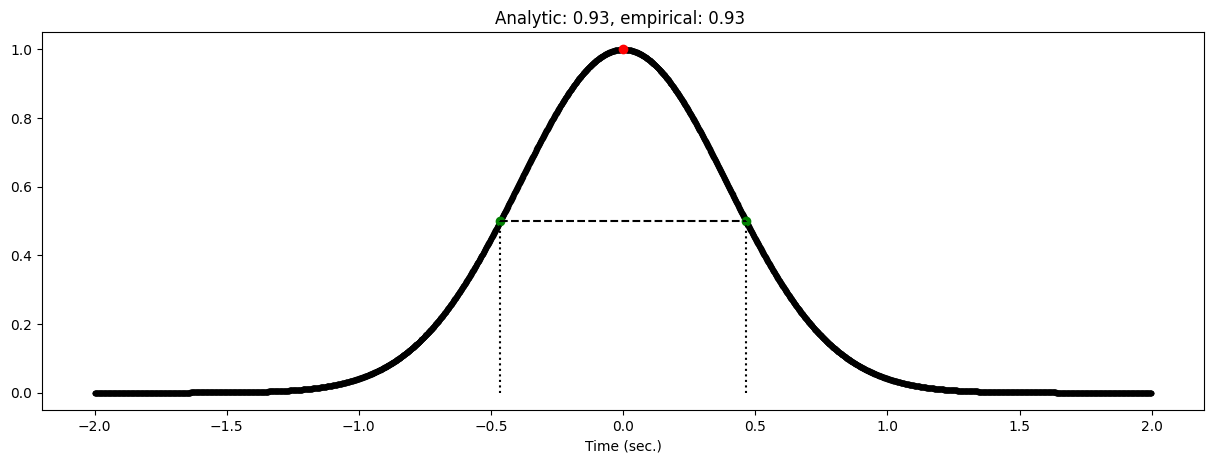

In [ ]:
## Gaussian

# simulation parameters
srate = 1000
time  = np.arange(-2,2,1/srate)
fwhmA = .93 # seconds

gauswin = np.exp( -(4*np.log(2)*time**2) / fwhmA**2 )
gauswinNorm = gauswin / np.max(gauswin) #  normalize


# find the peak point
peakpnt = np.where( gauswin==np.max(gauswin) )[0][0]

# find 50% PREpeak point
prepeak = np.argmin( (gauswinNorm[0:peakpnt]-.5)**2 )


# find 50% POSTpeak point
pstpeak = np.argmin( (gauswinNorm[peakpnt:]-.5)**2 )
pstpeak = pstpeak + peakpnt  # adjust


# compute empirical FWHM
fwhmE = time[pstpeak] - time[prepeak]


# plot normalized gaussian window
plt.plot(time,gauswinNorm,'k.')



# plot the points
plt.plot(time[peakpnt],gauswinNorm[peakpnt],'ro')
plt.plot(time[prepeak],gauswinNorm[prepeak],'go')
plt.plot(time[pstpeak],gauswinNorm[pstpeak],'go')

# plot line for reference
plt.plot([time[prepeak],time[pstpeak]],[gauswinNorm[prepeak],gauswinNorm[pstpeak]],'k--')
plt.plot([time[prepeak],time[prepeak]],[0, gauswinNorm[prepeak]],'k:')
plt.plot([time[pstpeak],time[pstpeak]],[0, gauswinNorm[prepeak]],'k:')
plt.xlabel('Time (sec.)')

plt.title('Analytic: %g, empirical: %g ' %(fwhmA,fwhmE))


plt.show()

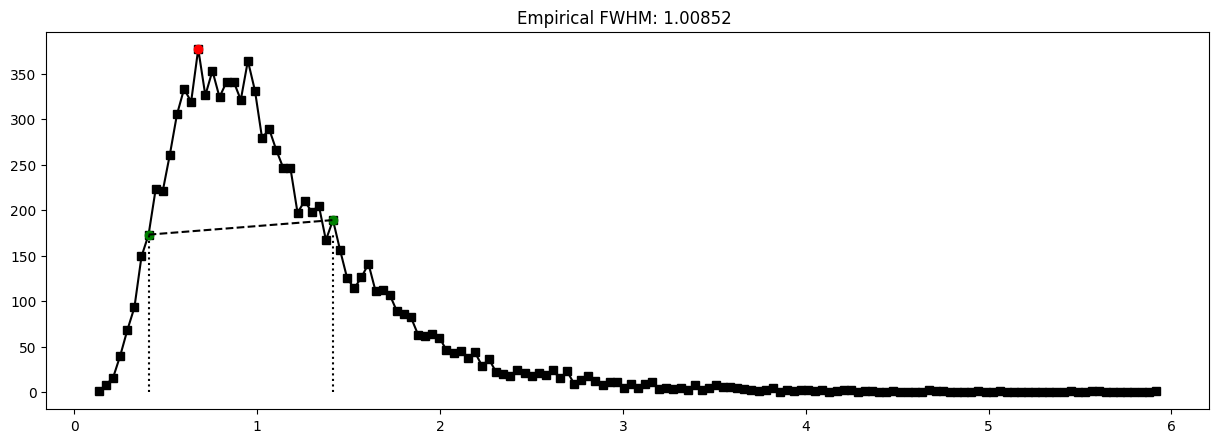

In [ ]:
## example with asymmetric shape

# generate asymmetric distribution
fx,x = np.histogram(np.exp(.5*np.random.randn(10000,1)),150)

# normalization necessary here!
fxNorm = fx/np.max(fx)

# plot the function
plt.plot(x[0:-1],fx,'ks-')


# find peak point
peakpnt = np.where( fxNorm==np.max(fxNorm) )[0][0]


# find 50% PREpeak point
prepeak = np.argmin((fxNorm[:peakpnt]-.5)**2)


# find 50% POSTpeak point
pstpeak = np.argmin((fxNorm[peakpnt:-1]-.5)**2)
pstpeak = pstpeak + peakpnt  # adjust


# compute empirical FWHM
fwhmE = x[pstpeak] - x[prepeak]



# plot the points
plt.plot(x[peakpnt],fx[peakpnt],'ro')
plt.plot(x[prepeak],fx[prepeak],'go')
plt.plot(x[pstpeak],fx[pstpeak],'go')


# plot line for reference
plt.plot([x[prepeak],x[pstpeak]],[fx[prepeak], fx[pstpeak]],'k--')
plt.plot([x[prepeak],x[prepeak]],[0, fx[prepeak]],'k:')
plt.plot([x[pstpeak],x[pstpeak]],[0, fx[prepeak]],'k:')

plt.title('Empirical FWHM: %g ' %fwhmE)
plt.show()

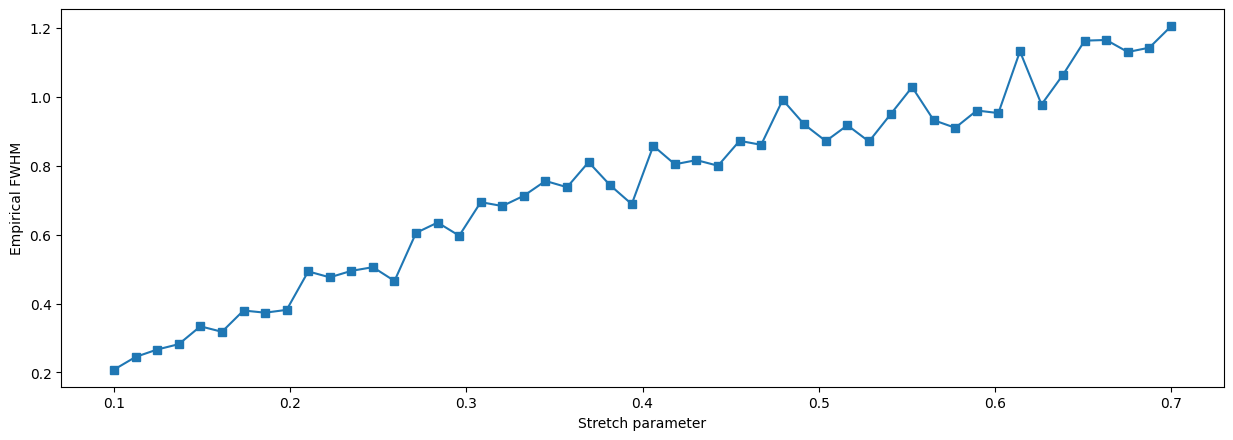

In [ ]:
## an interesting aside...

# a range of standard deviations
sds = np.linspace(.1,.7,50)
fwhmE = np.zeros(len(sds))

for i in range(0,len(sds)):
    
    # new data
    fx,x = np.histogram(np.exp(sds[i]*np.random.randn(10000)),150)
    
    # normalization necessary here!
    fxNorm = fx/np.max(fx)
    
    # find peak point
    peakpnt = np.where( fxNorm==np.max(fxNorm) )[0][0]
    prepeak = np.argmin( (fxNorm[:peakpnt]-.5)**2 )
    pstpeak = np.argmin( (fxNorm[peakpnt:]-.5)**2 )
    pstpeak = pstpeak + peakpnt  # adjust
    
    # FWHM
    fwhmE[i] = x[pstpeak] - x[prepeak]


# plot
plt.plot(sds,fwhmE,'s-')
plt.xlabel('Stretch parameter')
plt.ylabel('Empirical FWHM')
plt.show()